# Linear Support Vector Machine

This notebook covers a Python-based gradient descent solution for a support vector machine. It follows the course slides and is not intended to stand on its own. (In this notebook we assume the bias b = 0, so only w is estimated.)

## Binary Classifier

Let's load in the data for a two class classification problem and then build a binary classifier on this data. Following the course slides we will build a linear classifier as a support vector machine. This classifer tries to maximize the margin separating the classes.

Let's start by importing some libraries.

In [10]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# Let's make up some random data to use to build our SVM classifier
data = pd.DataFrame(np.zeros((500, 3)), columns=['x1', 'x2', 'y'])

for i in range(len(data.index)):
    x1 = random.randint(20,100)
    if np.random.random() > 0.5:
        data.iloc[i,0] = 1.0 * x1 
        data.iloc[i,1] = 0.25 * x1 + 50.0 * (random.random() - 0.5) + 65.0
        data.iloc[i,2] = 1.0
    else:
        data.iloc[i,0] = 1.0 * x1
        data.iloc[i,1] = 0.24 * x1 + 50.0 * (random.random() - 0.5) + 0.0 
        data.iloc[i,2] = -1.0
    
# Add in a stray point
data.iloc[0,0] = 50.0
data.iloc[0,1] = 0.25 * x1 + 25.0
data.iloc[0,2] = 1.0

# Now let's normalize this data.

data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()

data.head()
data.describe()

,x1,x2,y
count,5.000000e+02,5.000000e+02,500.000000
mean,-7.815970e-17,-8.881784e-17,-0.064000
std,1.000000e+00,1.000000e+00,0.998949
min,-1.695938e+00,-1.753387e+00,-1.000000
25%,-8.475022e-01,-9.240004e-01,-1.000000
50%,9.332791e-04,-1.891239e-01,-1.000000
75%,8.917906e-01,8.987061e-01,1.000000
max,1.697804e+00,1.833367e+00,1.000000


In [12]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

X = np.matrix(X.values)
y = np.matrix(y.values)


Let's plot it to get a better idea of what the data looks like.

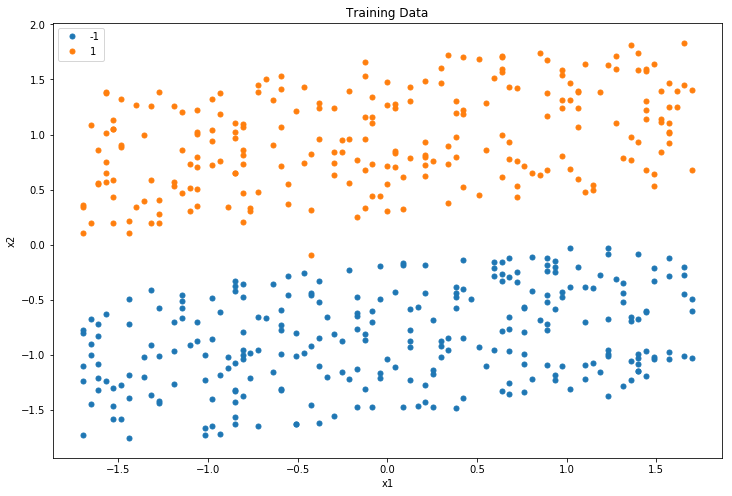

In [13]:
# Sloppy function for plotting our data
def plot_data(X, y):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y > 0
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='-1')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Training Data')
    plt.show()

# Sloppy function for plotting our data
def plot_data_and_SVM(X, y, w, b):
    
    x_classifier = np.transpose(np.matrix(np.linspace(X[:,0].min(), X[:,1].max(), 100)))
    y_classifier = (-w[0,0] * x_classifier - b) / w[0,1]
    y_classifier_margin1 = (-w[0,0] * x_classifier - b + 1.0) / w[0,1]
    y_classifier_margin2 = (-w[0,0] * x_classifier - b - 1.0) / w[0,1]
  
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y > 0
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='-1')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')
    
    ax.plot(x_classifier, y_classifier, 'r', label='Decision Surface')
    ax.plot(x_classifier, y_classifier_margin1, 'r', label='Margin')
    ax.plot(x_classifier, y_classifier_margin2, 'r', label='Margin')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Training Data')
    plt.show()
    
plot_data(X, y)

Now let's implement the SVM using gradient descent to minimize the cost function. You can see the derivation for these in the course notes.

First we'll create a function to compute the cost of a given solution characterized by the weights w and bias b.

In [5]:
def computeCost(X, y, w, b, C):
    N = X.shape[0]
    lamb = 2.0 / (N * C)
    inner = lamb * np.inner(w,w) / 2.0 + np.maximum(0.0, 1.0 - np.multiply(1.0 * y, np.dot(X, np.transpose(w)) + b))
    return np.sum(inner) / float(N)

So far so good.  Now we need to define a function to perform gradient descent on the parameters w and b using the update rules defined in the course notes.

In [6]:
def gradientDescent(X, y, w, b, C, iters):
    update = np.matrix(np.zeros(w.shape))
    cost = np.zeros(iters)
    N = X.shape[0]
    lamb = 2.0 / (N * C)
    
    X1 = np.hstack((X, np.matrix(np.ones((X.shape[0],1)))))
    wb = np.hstack((w, b))
    for t in range(1, iters):
        cost[t] = computeCost(X, y, wb[0:1, 0:2], wb[0, 2:3], C)
        eta = 1.0 / (lamb * float(t))
        k = random.randint(0, N-1)
        yfx = float(y[k]) * (np.dot(X1[k,:], np.transpose(wb)))
        if yfx < 1:
            wb = (1.0 - 1.0/float(t)) * wb + eta * float(y[k]) * X1[k,:]
        else:
            wb = (1.0 - 1.0/float(t)) * wb 
        project = np.min((1.0, 1.0/np.sqrt(lamb * np.dot(wb, np.transpose(wb)))))
        wb = project * wb
        
    return wb[0:1, 0:2], wb[0, 2:3], cost

Initialize some additional variables - the slack variable penalty C, the number of iterations, and a starting point for w. Then run the Pegasos gradient descent algorithm to fit our parameters w to the training set.

Cost =  [  0.00000000e+00   1.00000000e+00   7.41098124e+01 ...,   5.01393407e-04
   5.01383379e-04   5.01373351e-04]


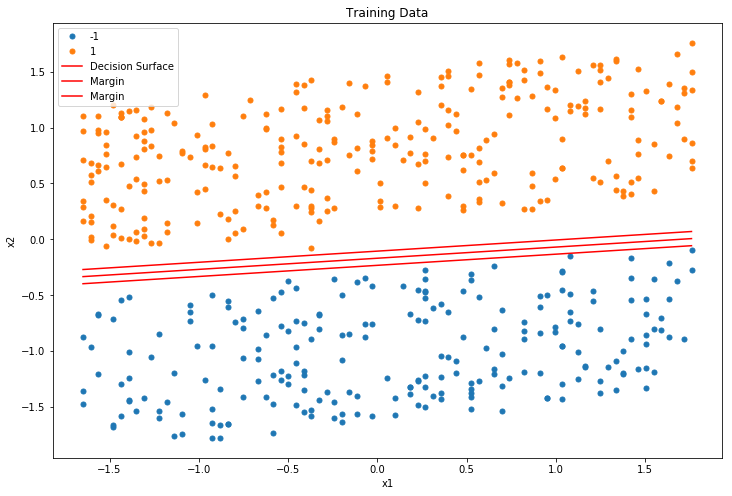

In [7]:
C = 1000.0
iters = 100000
w = np.matrix(np.array([0.0,0.0]))
b = np.matrix(np.array([0.0]))
w, b, cost = gradientDescent(X, y, w, b, C, iters)
print "Cost = ", cost
plot_data_and_SVM(X, y, w, b)

Now let's try this with a smaller penalty C on samples that are on the wrong side of their support vector.

Cost =  [  0.00000000e+00   1.00000000e+00   4.85472333e+01 ...,   2.49259469e-03
   2.49261939e-03   2.49264409e-03]


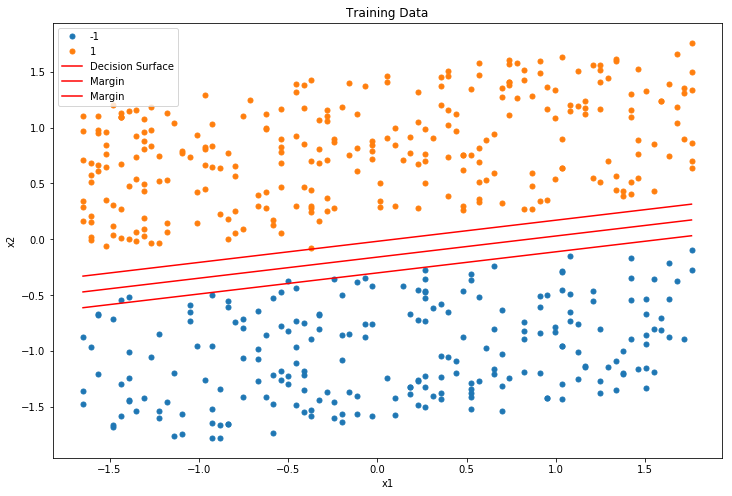

In [8]:
C = 100.0
iters = 100000
w = np.matrix(np.array([0.0,0.0]))
b = np.matrix(np.array([0.0]))
w, b, cost = gradientDescent(X, y, w, b, C, iters)
print "Cost = ", cost
plot_data_and_SVM(X, y, w, b)

Cost =  [ 0.          1.          5.50427354 ...,  0.03276459  0.03276459
  0.03276459]


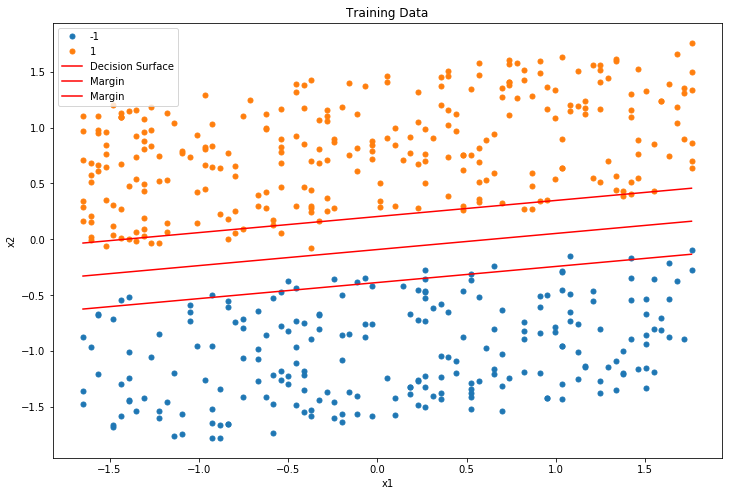

In [9]:
C = 1.0
iters = 100000
w = np.matrix(np.array([0.0,0.0]))
b = np.matrix(np.array([0.0]))
w, b, cost = gradientDescent(X, y, w, b, C, iters)
print "Cost = ", cost
plot_data_and_SVM(X, y, w, b)